# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
os.chdir("/content/drive/MyDrive/Colab Notebooks")

Mounted at /content/drive


**Installing surprise library**

In [1]:
!pip install scikit-surprise

In [6]:
!pip install "numpy<2.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 81.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## **Importing the necessary libraries and overview of the dataset**

In [1]:
# To compute the accuracy of the models
import numpy as np

from surprise import accuracy

# This class is used to parse a file containing ratings, data should be used in structure - user; item; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in the train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recomendation systems
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# For implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

In [2]:


# Used to ignore the warning given as output of the code
import warnings
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np, pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt

# Slightly advanced library for data visualization
import seaborn as sns

# A dictionary output that does not raise a key error
from collections import defaultdict

# A performance metrics in sklearn
from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
# Importing the dataset
ratings_electronics = pd.read_csv("ratings_Electronics.csv", names = ["user_id", "prod_id", "rating", "timestamp"])

# Droping the "timestamp" column
data = ratings_electronics.drop("timestamp", axis = 1)

# Copying the data to another DataFrame
df = data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

""" The ".items" method selects the key-value pair in the "ratings_count" dictionary
and iterates through them given that it is being apllied in a for loop.

 Taking into account the fact that a the key-value pair are two elements,
 by using "user, num_ratings" in the for loop in that order, it also asigns
  the key (user_id) to the "user" variable and the value (number of ratings)
  to the "num_ratings" variable at the same time. """
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

""" If the "num_ratings" of the user is smaller than the "RATINGS_CUTOFF" (set at 50)
it appends the user to the "remove_users" list. """

""" We create a boolean "df.user_id.isin(remove_users)" to check if the "user_id"
 in "df" is also in the "remove_users" list.

 Then the "~" negates the boolean series, only selecting the users that are not
 in the "remove_users" list.

 Finally the "df.loc" method selects only the rows of df
 corresponding to these selected users, updating the df DataFrame to contain
 only the data for users meeting the rating threshold.  """
df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

# We use the same process as we did for the users
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
# Check the number of rows and columns and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1310 to 7824427
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


- There are **65290 rows** and **3 columns** in the data after we filtered the users and products with the rating tresholds.

### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


- The **user_id** and the **prod_id** are both objects since they are stored as text and the **rating** is a float given that it includes decimals.

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


- There are **0** missing values.

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
print(df_final["rating"].describe())

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


- The **average** rating is **4**, which is good.

- There's a substantial **standard deviation** of **0.98** with ratings ranging from 1 through 5.

- The **50% (median)** is a rating of **5**, which is impressive, and the **75%** is also 5, meaning there are a lot of good ratings.

### **Checking the rating distribution**

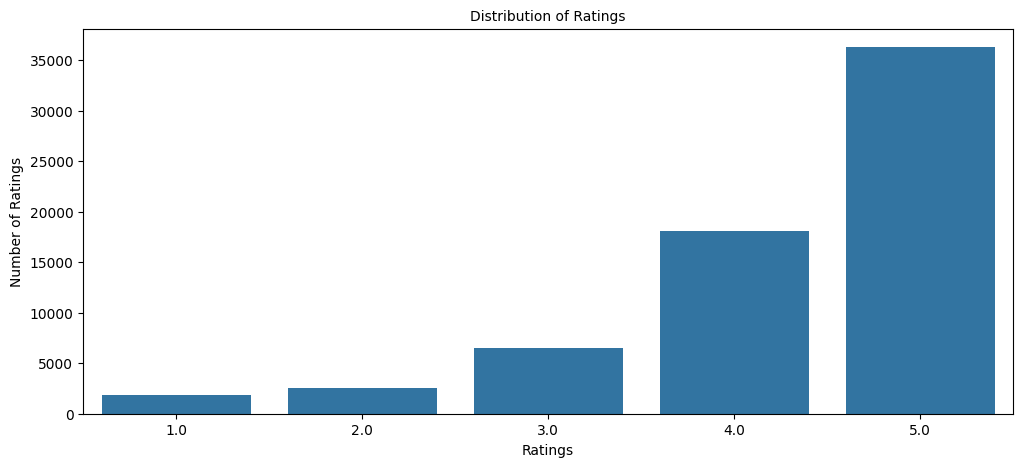

In [ ]:
# Create the bar plot and provide observations

#Fix the figure size
plt.figure(figsize = (12, 5))

""" The variable "ax" represents the plot axes (x,y).
In this case, x is the diferent ratings (1 through 5) and y
is the ratings count specified through ".countplot"
using the dataframe data ("data = data")."""
ax = sns.countplot(x = "rating", data = df_final)

""" The "plt.tick_params" function is used to customize the appearance
of tick marks and tick labels on the axes of the plot.
 In this case with "labelsize = 10" we adjust the size
 of the numbers and text along the axes (the rating numbers
 and the rating count numbers)."""
plt.tick_params(labelsize = 10)

# We set the title of the plot
plt.title("Distribution of Ratings", fontsize = 10)

# We set the x label of the plot
plt.xlabel("Ratings", fontsize = 10)

# We set the ylabel of the plot
plt.ylabel("Number of Ratings", fontsize = 10)

# Display the plot
plt.show()

- The data is **highly skewed** towards Rating **"5"**, which has the highest rating count by far with around **35** thousand  ratings. In fact it is about the same size as all the other ratings combined.

- The number of Rating **4** is also substancially bigger than Rating **2 or 3** with around **18** thousand ratings. Thus, making it bigger than Rating **2 and 3** combined (about double the size of both combined). And it is even bigger than Rating **1,2 and 3** combined.

- This means that the large majority of people only bother to rate a product when it's really good.

- That is, at least in a consistant manner, since we dropped users who had less than **50** ratings we see that, people who rate products regularly (at least 50 times) leave good ratings, in the majority of cases, and go through the trouble of rating the products they bought, because they had a good experience.

- We could say that the negative reviews of ** 1 and 2** are given sporadically when people have a really bad experience. At least for people with more than **50** ratings. If we were to review the entire dataset the number of **1** ratings would be a lot bigger, meaning that people who have a really bad experience wouldn't leave a lot of ratings, just the times their experience was really bad or really good.

- The number of ratings are also linear, as we see a clear linear increase from **1 to 5**.

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data

# Number of unique users
df_final["user_id"].nunique()

1540

In [ ]:
# Number of unique products
df_final["prod_id"].nunique()

5689

 **Observations:**

 - There are **1540 unique users** in the dataset.

 - There are **5689 unique products** in the dataset.

 - As per the number of unique users and products, there is a **possibility of 1540*5689 = 8,761,060 million ratings** in the dataset. But **we only have 65290 ratings**, i.e. not every user has rated every product in dataset. Now this is obviously not feasible, but it shows that there are still a lot of products to be recomended and rated. We can build a recommendation system to recommend a product to users which they have not seen nor purchased.  

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings

""" The method ".value_counts()" is a pandas method that is applied to a Series
 (in this case, the "user_id" column).
 It counts the occurrences of each unique value in the Series and returns
 a new Series where the index is the unique values and the values
 are their corresponding counts"""
df_final["user_id"].value_counts().head(10)

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**Observations:**

- There are users with a lot of products rated, the number 1 user with the most ratings has **295** ratings and the number 10 has **179**. That's a really susbtantial amount of products rated.

- However, even for the number 1 user, for example, there is still a possibility of **5689-295 = 5394** more interactions as we have **5689 unique products** (with over 5 ratings) in our database.

- Now, once again, this is obviously not feasible, but it still shows that there are a lot of products to be recomended and rated. We can build a recommendation system to predict which products these users (and all other users) are most likely to buy.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product

""" The "data.groupby" function groups dataframe by the prod_id column,
 gathering all the rows with the same prod_id together.
["ratings"] selects the ratings column.
"lambda x:" creates an anonymous function that takes a single argument
(x, which will be the ratings column for each group).
lambda funtions are typicaly single use functions, for elements that aren't repeted,
unlike the def function.
"pd.to_numeric(x, errors="coerce"):" ensures that the ratings column is treated as numeric data,
 using "errors="coerce" to handle typos or missing data like NaN.
Finally, the average of the (now numeric) ratings is calculated
 for each group (product) using ".mean()". """
average_rating = df_final.groupby("prod_id")["rating"].apply(lambda x: pd.to_numeric(x, errors ="coerce").mean())

# Calculate the count of ratings for each product
count_rating = df_final.groupby("prod_id").count()["rating"]

# Create a dataframe with calculated average and count of ratings
# We use a dictionary to define the names of the columns of the new dataframe
final_rating = pd.DataFrame({"avg_rating": average_rating, "rating_count": count_rating})

# Sort the dataframe by average of ratings in the descending order
final_rating.sort_values(by=["avg_rating"], ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head()

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
""" "Data" is a flexible paramether able to accept different dataframes,
"n" is the number of top products to recommend and "min_intereaction" sets the minimum number
of ratings a product must have to be considered for recomendation,
 which is set to 100 by default."""
def top_n_products (data,n, min_interaction = 100):

  # Finding products with minimum number of interactions
  """ While data is a flexible paramether, in this instance it implies that the dataframe used
  contains a column named "rating_count". """
  recomendations = data[data["rating_count"] > min_interaction]

  # Sorting values with respect to average rating
  """ The funtion also implies that the dataframe used has an "avg_rating" column. """
  recomendations = recomendations.sort_values(by = "avg_rating", ascending = False)

  """ :n is the slice notation and selects elements from the beginning of the index (position 0) up to,
  but not including, the element at position n.
  Therefore, :n does not include n itself. It selects elements from index 0 to index n-1, effectively returning n elements in total.
  For example If n is 5, the slicing [:n] would select elements at positions 0, 1, 2, 3, and 4,
  resulting in a total of 5 elements being returned. """
  return recomendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
list(top_n_products(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [3]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:

def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    """ With the line "for uid, user_ratings in user_est_true.items()"
     "uid" is assigned to the user ID (the key of the dictionary "user_est_true")
     and "user_ratings" is assigned to the value, which is a list of tuples containing the "est" and the "true_r"
     for each user.

     Then, the tuple is unpacked with the lines "for (_,true_r) in user_ratings)"
     and "for (est, _) in user_ratings[:k]". """
    predictions = model.test(testset)

    """ We use the "_" to skip the "iid" and "details" from the model. """
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        """ We use "_" to skip "est". """
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        """ We use "_" to skip "true_r". """
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (0,5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[["user_id", "prod_id", "rating"]], reader)

# Splitting the data into train and test datasets
trainset, testset =train_test_split(data, test_size = 0.2, random_state = 42 )

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
# Declaring the similarity options
""" The cosine similarity is the dot product divided by the product of the magnitudes.
( We get the rating vector for the users being compared.
We calculate the dot product of the two vectors by multiplying the corresponding elements
 and adding them all up.
Then, we calculate the magnitude of each rating vector by using the euclidean norm
[square root of the sum of squares] of each vector.
Divide the dot product by the product of the magnitudes[of each vector].)
This cosine similarity value ranges from -1 to 1, 1 (very similar users),
0 (no similarity) and -1 (very dissimilar users)."""
sim_options = {"name": "cosine",
               "user_based": True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
""" KNNBasic  starts by calculating the similarity between all pairs of users
 using, in this case, cosine similarity. (creating a similarity matrix where each element
  represents the similarity between two users.)
Then, it finds the k-nearest neighbors of the specified user.
(the k users who are most similar to the target user based on the similarity matrix. )
Then, it aggregates their ratings for the specified item (using a weighted average by default).
Finally, it eturns the predicted rating for the user-item pair. """
sim_user_user = KNNBasic(sim_options = sim_options, verbose = False, random_state =1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


- We have calculated **RMSE** to check **how far the overall predicted ratings** are from the **actual ratings.** There's a difference of **1 star** which isn't great, but we'll try to improve it with further optimization of the model.

- Intuition of Recall - We are getting a **recall of 0.858,** which means **out of all relevant products 85.8% are recommended.

- Intuition of Precision - We are getting a **precision of 0.855**, which means **out of all the recommended products 85.5% are relevant.

- Here **F_1 score** of the **baseline model is 0.856. It indicates that **mostly recommended products were relevant and relevant products were recommended** to the user. Once again, we will try to improve this later by using **GridSearchCV by tuning different hyperparameters** of this algorithm.


Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

- The above output show that **the actual rating for this user_item pair is 5 and the predicted rating is 3.40** by the **user-user-smilarity-based baseline model.** This implies that the model is under-estimating the ratings.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
"""df_final["prod_id"] != "1400501466" creates a boolean mask
 – True for rows where the prod_id is not "1400501466", and False otherwise.
 ["user_id"] selects the user_id column from the filtered DataFrame.
 This mask is applied to df_final, selecting only the rows where the condition is True
 (rows representing interactions with products other than "1400501466").
 Now we have a Series containing the user_id values of users who interacted with products other than "1400501466".
 The ".unique()" method is applied to the user_id Series to extract only the unique user IDs, removing any duplicates. """
unique_user_not_interacted = df_final[df_final["prod_id"] != "1400501466"]["user_id"].unique()
print(unique_user_not_interacted)

['A2ZR3YTMEEIIZ4' 'A3CLWR1UUZT6TG' 'A5JLAU2ARJ0BO' ... 'A215WH6RUDUCMP'
 'A38C12950IM24P' 'A2J4XMWKR8PPD0']


* It can be observed from the above list that **user "A2ZR3YTMEEIIZ4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- As we can see the estimated rating for this user-item pair is 4.29 based on this similarity based baseline model.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
""" MSD (Mean Squared Difference) The MSD formula essentially calculates
the average squared difference in ratings between two users for the items they have both rated.
 The more similar their ratings are, the smaller the squared differences will be,
  resulting in a lower (and more negative) MSD value.

  This might seem counterintuitive, however, the score comes out negative
  because the formula is inverted by multiplying by -1. This is done for easier readability
  when comparing different simmilarity measures, where higher values represent higher similarity.
  The original formula is "(MSD(u, v) = - 1 / |Iuv| * Σ(rui - rvi)^2.)."
  However, it is then changed to "MSD(u, v) = -1 * (1 / |Iuv|) * Σ(rui - rvi)^2" due to
  arithmetic equiavalence (given the fact that dividing by a number is the same as multiplying
  by its reciprocal. [dividing by |Iuv| is the same as multiplying by (1/ |Iuv|).])
  Then, to simplify for clarity sake, we rearange the formula to
   "MSD(u, v) = (-1 * Σ(rui - rvi)^2) / |Iuv|" in order to emphasize that the negation applies
   to the sum of squared differences before the division by the number of shared items (|Iuv|).

  MSD is a relatively simple and fast similarity metric as it focuses
  on the absolute differences in ratings. However, it can be sensitive to the scale of ratings.
  If one user generally gives higher ratings than another (even if their preferences are similar),
  the MSD might be large. It's often used as a baseline for comparison with other similarity metrics.
  It performs well in practice, and it's computationally less expensive
  compared to Pearson-based similarities in the surprise library.

  Pearson Pearson correlation measures the linear relationship between the ratings of two users.
  It considers how much the ratings of one user tend to deviate from their average rating
  in the same way that the ratings of another user deviate from their average rating.
  Values range from -1 (negative correlation) to +1 (positive correlation),
  with 0 indicating no correlation.

  The formula is
  Pearson(u, v) = Σ(rui - ru_mean)(rvi - rv_mean) / sqrt(Σ(rui - ru_mean)^2 * Σ(rvi - rv_mean)^2)
  The numerator, Σ(rui - ru_mean)(rvi - rv_mean), measures the co-variance
  between the ratings of two users.  It calculates how much user u's rating deviates
  from their average and multiplies it by how much user v's rating deviates from their average.
  By multiplying these deviations for each item and summing them up, we get a measure of
  how much the ratings of the two users tend to move together (positive co-variance)
  or in opposite directions (negative co-variance).

  The denominator, sqrt(Σ(rui - ru_mean)^2 * Σ(rvi - rv_mean)^2),
  calculates the product of the standard deviations of the two users' ratings.
  First, it calculates the sum of squared deviations for each vector separately,
  measuring how spread out the ratings of each user are around their own average.
  By taking the square root of the product of these sums, it essentially calculates the product
  of the standard deviations of each vector. This is used to normalize the co-variance
  (numerator) by the individual variability of each vector.

  This is important because we want to compare the similarity of rating patterns
  regardless of whether one user tends to give higher ratings overall or has a wider
  range of ratings compared to another.  It also allows us to focus on the similarity
  of their rating patterns rather than just the absolute differences in their ratings.

  Pearson correlation is effective when you want to find users who have similar rating patterns,
  even if their absolute rating values differ.
  It's often more robust to rating scale differences between users compared to MSD.

  Pearson Baseline is similar to pearson correlation but it uses a baseline prediction instead of
  average user ratings. The baseline prediction can be, for example, the average rating
  of the item instead of the average rating of the user like in pearson correlation.
  Then, in the calculations you calculate the deviation from that baseline and use
  that deviation from baseline predictions instead of deviations from average user ratings.

  The baselines are simbolized as (bui, bvi), making the formula
  Pearson_Baseline(u, v) = Σ(rui - bui)(rvi - bvi) / sqrt(Σ(rui - bui)^2 * Σ(rvi - bvi)^2).

  It is an improvement over standard Pearson correlation,
  because it takes into account user and item biases.
  This results in more accurate similarity calculations.
  It also recognizes that some users might generally rate items higher than others (user bias),
  and some items might generally receive higher ratings than others (item bias).
  By subtracting these biases, the similarity calculation focuses on the genuine preferences
  of the users, as opposed to their overall rating tendencies.

  Pearson Baseline is used when you want a more robust similarity calculation
  that's less likely to be influenced by systematic biases in rating data.

  However, both Pearson and Pearson Baseline involve more computations to perform,
  which might affect the training time, making MSD a more efficient alternative in many cases. """
param_grid = { "K": [20, 30, 40], "min_k": [3, 6, 9],
              "sim_options": {"name" : ["msd", "cosine"],
                              "user_based": [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
""" "GridSearchCV" is the tool that performs the search for the best hyperparameters.
 It systematically tries all combinations defined in "param_grid."

 The parameter "cv = 3" means the "GridSearchCV" tool will use 3-fold cross-validation.
  The data is split into 3 parts, and the model is trained and tested 3 times,
  each time using a different part for testing.
  This helps to ensure the model's performance is robust. """
gs = GridSearchCV(KNNBasic, param_grid, measures = ["rmse"], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Best RMSE score
""" The "gs.best_score function prints the lowest RMSE achieved during the search,
 indicating the best model performance. """
print(gs.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
""" The "gs.best_params" function prints the combination of hyperparameters
 that resulted in the best RMSE score.
 This tells us the optimal settings for our recommendation system """
print(gs.best_params["rmse"])

0.9705879136177992
{'K': 20, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {"name": "cosine",
               "user_based": True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options = sim_options, k = 20, min_k = 6, random_State = 1, verbose = False)

# Training the algorithm on the trainset
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k =10
precision_recall_at_k(sim_user_user_optimized)

RMSE: 0.9529
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


- We can serr from above that after tuning hyperparameters, **F_1 score of the tuned model has increased a bit as compared to the baseline model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

The model still doesn't have enough neighbors and it's still resorting to the average rating of 4.29. We'll se if this changes with SVD. If not, we'll change the parameters, perhaps to k = 30, min_k = 3 and using msd.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0,5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    """ The pivot table creates a dataframe shaped like a spreadsheet. """
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    """ The ".isnull()" extracts the columns with the null values into a series,
    the ".index" accesses the index of the null values
    and the ".tolist()" creates a list out of that series
    with the product ids that have null values.  """
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        """ The "user_id" is one of the flexible parameters created in the beginning of the def function
        and the "item_id" comes from the "non_interacted_products" list created previously."""
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recomendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, sim_user_user)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recomendations, columns = ["prod_id", "predicted_ratings"])

,prod_id,predicted_ratings
0,1400599997,5
1,B00000DM9W,5
2,B00000K4KH,5
3,B00001W0DI,5
4,B00002EQCW,5


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Declaring the similarity options
sim_options = {"name": "cosine",
               "user_based": False}

# KNN algorithm is used to find desired similar items. Use random_state=1
sim_item_item = KNNBasic(sim_options = sim_options, random_state = 1, verbose = False)

# Train the algorithm on the trainset, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


- The baseline model is giving an F_1 score of **about 84%**. This is already pretty good, but we will see if we can still **improve this later by using GridSearchCV** by tuning different hyperparameters of this algorithm. We will also try to improve RMSE which is **0.9950** as for now.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
sim_item_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

- So we are getting an actual prediction of **4.27.** We will see if we can improve this later.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
sim_item_item.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

For non interacted product we are still not getting enough neighbors and still getting the average.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }
# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9754417259305758
{'k': 20, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, random_state = 1, verbose = False)

# Training the algorithm on the trainset
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


We can see from above that after tuning hyperparameters, **everything improved**. Even though it was a small inprovment, F_1 is slightly higher, so is precision, recall improved and RMSE is slightly lower.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
sim_item_item_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_item_item_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- Altough the first prediction was actually good, with**4.67** when the actual rating was 5, we continue to have the same problem with the non interacted prediction.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
sim_item_item_optimized.get_neighbors(0, k = 5)

[29, 53, 67, 106, 151]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns = ["prod_id", "predicted_ratings"])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state = 1)

# Training the algorithm on the trainset
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


- Recall is the same compared to KNN, everything else improved. RMSE decreased and is at **0.8882** precision imporved with **0.853** and F_1 rose to **0.866.**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

- SVD predicted **4.08** when the real score was **5**. We will try to improve that with hyperparemeter tuning.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.40037568046934, details={'was_impossible': False})

- We are finally getting a prediction and with SVD we seem to have enough neighbors. **4.40** doesn't seem like a bad prediction.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
""" The "n_epochs" parameter represents the number of times the SVD algorithm will iterate over the data

The "lr_all" parameter is the learning rate, which controls how quickly the model adjusts its parameters (values to test
It determines the step size taken during the model's training process by controling
how much the model's parameters are adjusted in response to the error it observes during training.
If you imagine you are trying to find the lowest point in a valley (corresponding to the global minimum),
the learning rate is like the size of the steps you take as you walk down that valley.
A large learning rate might be faster, but the model might diverge and fail to converge to a good solution
(overshooting the lowest point and oscillate around it.)
However, small learing rate might be more precise, but can make the training process very slow
and the model may get stuck in a local minimum instead of finding the global minimum.

The "reg_all" parameter is the regularization term, which helps prevent overfitting
Regularization adds a penalty to the model's complexity by discouraging large values
for the model's parameters. This penalty is incorporated into the loss function
that the model tries to minimize during training.
High regularization might simply the model by forcing parameters towards zero,
reducing overfitting but potentially underfitting (not capturing enough patterns in the data).
Low regularization allows the model to become more complex and fit the training data closely,
but increases the risk of overfitting.


The "SVD" parameter specifies that we are optimizing the SVD model.

SVD is a matrix factorization technique that decomposes a matrix into three smaller matrices.
In recommendation systems, we typically apply SVD to the user-item interaction matrix.
 You start with a matrix representing user-item interactions, often sparse.
 Then, SVD breaks down this interaction matrix into three components:

U: A matrix representing user features or latent factors
 (hidden characteristics influencing user preferences).
Σ: A diagonal matrix containing singular values,
 representing the importance of each latent factor.
VT: The transpose of a matrix representing item features or latent factors
 (hidden characteristics of items)

 Typically, a smaller number of latent factors are selected
(those with the highest singular values), effectively reducing the dimensionality of the data.
This captures the most important patterns in user-item interactions.

These factors might represent genres, directors or actors in movies, ingredients in recipes,
or styles of clothing. These are features that are not explicitly present in the data,
but are inferred from patterns in user behavior.
By focusing on the most important latent factors, SVD simplifies the data
and makes it easier to identify similarities between users and items.
The prediction process is based on the assumption that users who share similar latent factors
will also have similar preferences for items.

To predict a rating for a user-item pair, you take the corresponding
user and item feature vectors(from U and VT, respectively),
weight them by the singular values(from Σ), and combine them.
This essentially estimates how well a user's preferences align with an item's characteristics.

The formula is 𝑟̂𝑢𝑖 = 𝜇 + 𝑏𝑢 + 𝑏𝑖 + 𝑞𝑇𝑖 * 𝑝𝑢 where:
𝑟̂𝑢𝑖 is the predicted rating.
μ is the global average rating.
b_u is the user bias.
b_i is the item bias.
q_i is the latent factor vector for item i.
p_u is the latent factor vector for user u.

It can effectively work with sparse matrices containing many missing values.
It is computationally intensive, but it can be optimized for large datasets,
making it suitable for real-world applications.

SVD struggles to make recommendations for new users or items with limited interaction history,
as it relies on existing patterns.

However, it can overcome this cold star problem, specific to limited interaction history,
with Stochastic Gradient Descent (SGD).

Stochastic gradient descent is an iterative optimization algorithm used to minimize
the loss function and find the optimal values for the model's parameters which are biases
and latent factors.

First, it initializes the models parameters with random values. This is what allows it to overcome
the cold start problem, because, altough SVD is good at working with missing values in ratings,
it struggles with a low amount biases and latent factors which come with a limited interaction history.
Then, it iterates through the training data and performs prediction, error calculation
and parameter updating for each rating.

- The model predicts the rating for the current user-item pair using the current parameter values.
- It calculates the difference between the predicted rating and the actual rating. (the error)
- The model's parameters are updated slightly in a direction that reduces the error.
This update is based on the gradient of the loss function, which indicates the direction of steepest ascent.
The "stochastic" part means that the update is performed using only one data point
(or a small batch) at a time, rather than the entire dataset.

Finally, the algorithm continues to iterate until the loss function converges to a minimum,
meaning the model's predictions are as accurate as possible given the data and the model's complexity.

The loss function preaciously mentioned measures the error or discrepancy
between the model's predicted ratings and the actual ratings in the training data.
The goal is to minimize this loss function during the training process
to make the model's predictions as accurate as possible.

The funtion is ∑𝑟𝑢𝑖∈𝑅train (𝑟𝑢𝑖−𝑟̂𝑢𝑖)^2+𝜆(𝑏^2𝑖+𝑏^2𝑢+‖𝑞𝑖‖^2+‖𝑝𝑢‖^2), where:
∑𝑟𝑢𝑖∈𝑅train is the sum over all observed ratings (𝑟𝑢𝑖) in the training dataset (𝑅train).
(𝑟𝑢𝑖−𝑟̂𝑢𝑖)^2 he squared difference between the actual rating (𝑟𝑢𝑖) and the predicted rating (𝑟̂𝑢𝑖).
This is the error for each individual rating.
𝜆(𝑏^2𝑖+𝑏^2𝑢+‖𝑞𝑖‖^2+‖𝑝𝑢‖^2) is the regularization term, which helps prevent overfitting
by adding a penalty to large parameter values.
𝜆 (lambda) is the regularization parameter, controlling the strength of the penalty.
𝑏𝑖 and 𝑏𝑢 are biases for items and users, respectively.
‖𝑞𝑖‖ and ‖𝑝𝑢‖ are the norms (magnitudes) of the item and user latent factor vectors, respectively.
"""

param_grid = {"n_epochs": [10, 20, 30], "lr_all": [0.001, 0.005, 0.01],
              "reg_all": [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs = GridSearchCV(SVD, param_grid, measures = ["rmse"], cv = 3, n_jobs = -1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score["rmse"])

# Combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.8999713621701634
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20, lr_all = 0.01, reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized = svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


- We only saw marginal changes in comparison to the model with out hyperparemeter tuning. RMSE is slightly improved from **0.8882** to **0.8808**, precision is slightly up from **0.853** to **0.854** and recall is slightly down from **0.88** to **0.878**. The changes were so marginal that the F_1 score remain the same at **0.866.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.216280997100113, details={'was_impossible': False})

### **Conclusion and Recommendations**

- We can see that svd model with tuned hyperparemeters improved its prediction slightly from **4.08** to **4.13** when the actual rating was **5**.
- However the prediction with no previous interaction descreased slightly from **4.40** to **4.22**.
- This might be improved with furter hyperparemeter tuning, dispite this, the tuned model is still the one with the best performance.
- And which ever way we choose to go from here in terms of model tuning, it certainly has to be with the SVD model as a basis.
- I say this because, it was the only model capable of gathering enough neighbors to form a prediction with no previous user-item interaction.
- If we look at the final metrics for the tuned SVD model, with RMSE of **0.8808**, precision of **0.854**, recall of  **0.878** and F_1 score of **0.866**, it is actually performing well.
- For further improvements, perhaps consider increasing epochs to 30 or 40, so maybe at first a range of [25, 30, 35], decrease learning rate slightly to [0.0075, 0,005] and increase the regularization term to 0.3 or 0.4, so maybe at first [0.25, 0.3, 0.35] and go from there, always checking results for improvements or diminishing values.